<a href="https://colab.research.google.com/github/cieluka/speech-processing/blob/main/speech_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchaudio
print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available()else "cpu")
print(device)

2.8.0+cu126
2.8.0+cu126
cuda


In [5]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

speech_file = download_asset("/content/0017_001731.wav")

/tmp/ipython-input-1088198228.py:5: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  speech_file = download_asset("/content/0017_001731.wav")


In [6]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("sample rate:",bundle.sample_rate)
print("labels:",bundle.get_labels())

sample rate: 16000
labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [7]:
model = bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


100%|██████████| 360M/360M [00:00<00:00, 385MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [8]:
IPython.display.Audio(speech_file)

In [9]:
waveform,sample_rate = torchaudio.load(speech_file)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [10]:
with torch.inference_mode():
  features,_ = model.extract_features(waveform)

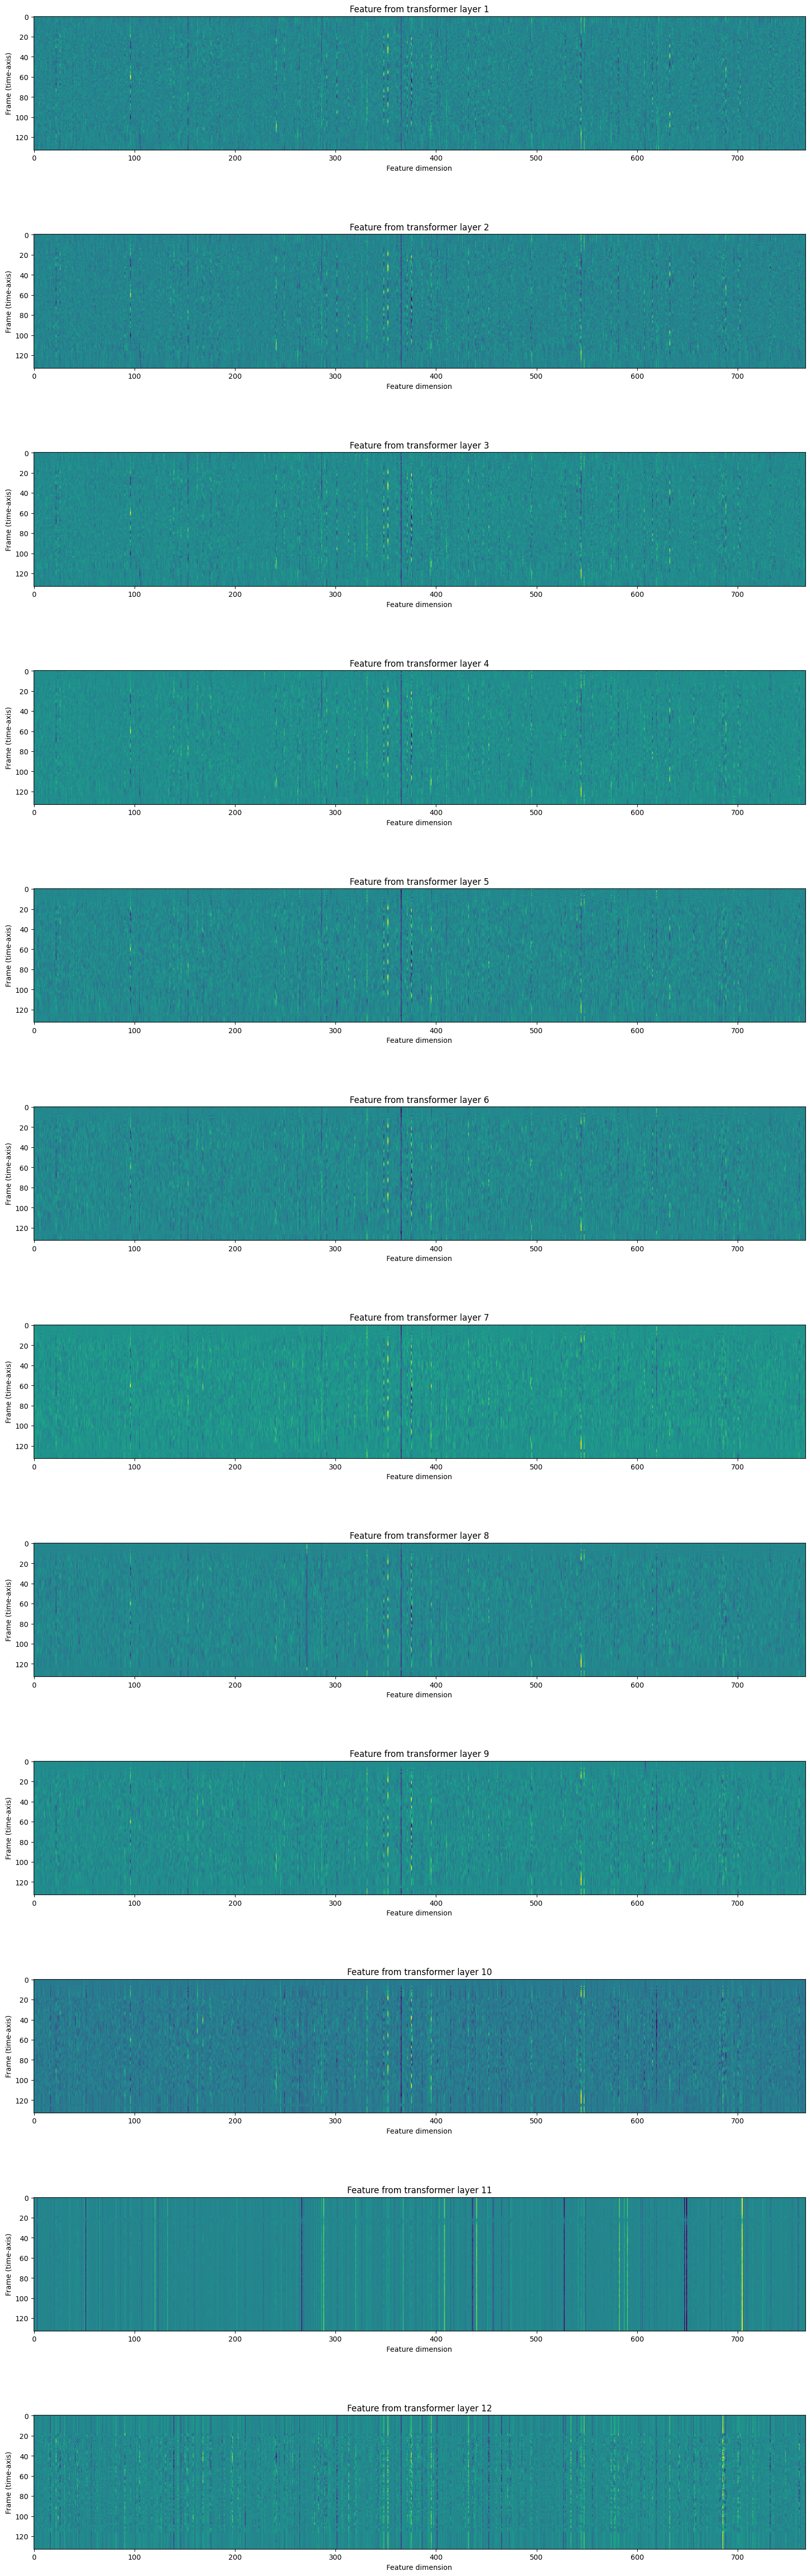

In [11]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [12]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


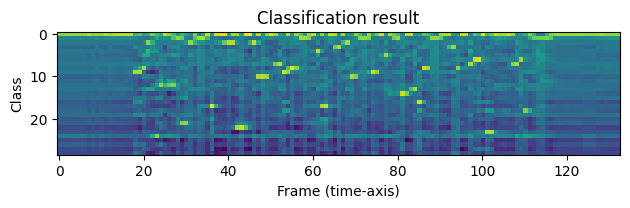

In [13]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [14]:
class GreedyCTCDecoder(torch.nn.Module):
  def __init__(self, labels, blank=0):
     super().__init__()
     self.labels = labels
     self.blank = blank
  def forward(self,emission:torch.Tensor) ->str:
    # emission shape: (batch, frame, num_labels)
    # We are interested in the first item in the batch
    emission = emission[0] # shape: (frame, num_labels)
    indices = torch.argmax(emission,dim =-1) # shape: (frame,)
    indices = torch.unique_consecutive(indices,dim =-1) # shape: (unique_frames,)
    indices = [i for i in indices if i != self.blank]
    return "".join([self.labels[i] for i in indices])

In [15]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission)

In [16]:
print(transcript)

SHE'LL|BE|FEVERISH|AFTER|SO|MUCH|THINKING|


In [17]:
import librosa
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [19]:
audio,rate = librosa.load("/content/0017_001731.wav",sr = 16000)
print(audio)
print(rate)

[ 0.0017395   0.00161743  0.00119019 ... -0.00033569 -0.00033569
 -0.00030518]
16000


In [20]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.12/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
input_values = tokenizer(audio,return_tensors="pt").input_values

In [22]:
logits = model(input_values).logits

In [23]:
prediction = torch.argmax(logits,dim=-1)

In [24]:
transcription = tokenizer.batch_decode(prediction)[0]
print(transcription)

SHE'LL BE FEVERISH AFTER SO MUCH THINKING
